In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sns.set(color_codes=True)


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

% matplotlib inline

# Question 1: Propensity score matching

## 1.1 A naive analysis
We start by importing the data and then split them into 2 subgroups: control and treated. We display some informations on the distributions and some plots.

In [2]:
#Display 2 dataframes from the same cell
from IPython.display import display

df = pd.read_csv('lalonde.csv')

#Create the 2 groups
treated = df.loc[df['treat'] == 1]
control = df.loc[df['treat'] == 0]

#Informations on both distributions while dropping irrelevant columns
display(treated.drop(['id', 'treat', 'black', 'hispan', 'married', 'nodegree'], axis=1).describe())
display(control.drop(['id', 'treat', 'black', 'hispan', 'married', 'nodegree'], axis=1).describe())

,age,educ,re74,re75,re78
count,185.000000,185.000000,185.000000,185.000000,185.000000
mean,25.816216,10.345946,2095.573689,1532.055314,6349.143530
std,7.155019,2.010650,4886.620353,3219.250870,7867.402218
min,17.000000,4.000000,0.000000,0.000000,0.000000
25%,20.000000,9.000000,0.000000,0.000000,485.229800
50%,25.000000,11.000000,0.000000,0.000000,4232.309000
75%,29.000000,12.000000,1291.468000,1817.284000,9642.999000
max,48.000000,16.000000,35040.070000,25142.240000,60307.930000


,age,educ,re74,re75,re78
count,429.000000,429.000000,429.000000,429.000000,429.000000
mean,28.030303,10.235431,5619.236506,2466.484443,6984.169742
std,10.786653,2.855238,6788.750796,3291.996183,7294.161791
min,16.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,9.000000,0.000000,0.000000,220.181300
50%,25.000000,11.000000,2547.047000,1086.726000,4975.505000
75%,35.000000,12.000000,9277.128000,3881.419000,11688.820000
max,55.000000,18.000000,25862.320000,18347.230000,25564.670000


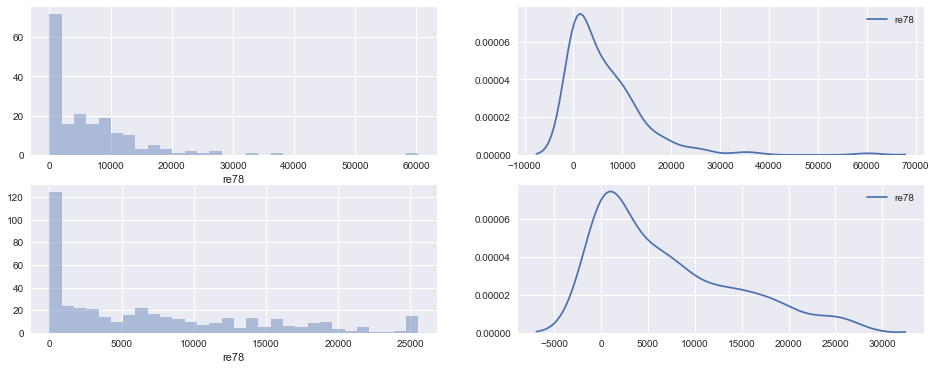

In [3]:
# Plots
fig, axes = plt.subplots(2,2, figsize=(16,6))
sns.distplot(treated['re78'], kde=False, ax=axes[0,0], bins=30)
sns.kdeplot(treated['re78'], ax=axes[0,1])
sns.distplot(control['re78'], kde=False, ax=axes[1,0], bins=30)
sns.kdeplot(control['re78'], ax=axes[1,1])


From a naive analysis, we could conclude that these distributions are quite the same. Even though, the controled group seems to have a more spread distribution but that could be related to the number of samples. In both cases, the mean is on the right side of the median and we can therefore conclude that there are both positively skewed.

## 1.2 A closer look at the data

### Distributions from the treated group

One should notice that we should analyse binary features (id, black, hispan, married, nodegree) differently than non-binary features (age, educ, re74, re75 and re78).
#### Non-Binary Features

In [4]:
def plot_distributions(table1, table2, exclude):
    '''Plot 3 graphs for each column of both dataframes (same number of columns needed): boxplot, distplot and kdeplot.
    Possibility to exclude some features. '''
    fig, axes = plt.subplots(len(table1.drop(exclude, axis=1).columns), 3, figsize=(16,10))
    i = 0
    for col in table1.drop(exclude, axis=1):
        '''print('Comparaison of the column {}:'.format(col))'''
        sns.boxplot(table1[col], orient='h', width=0.4, ax=axes[i, 0])
        sns.boxplot(table2[col], orient='h', width=0.4, ax=axes[i, 0])

        sns.distplot(table1[col], kde=False, ax=axes[i,1], bins=30).set_title(col)
        sns.distplot(table2[col], kde=False, ax=axes[i,1], bins=30)

        sns.kdeplot(table1[col], ax=axes[i,2])
        sns.kdeplot(table2[col], ax=axes[i,2])
        i=i+1
        
    plt.show()

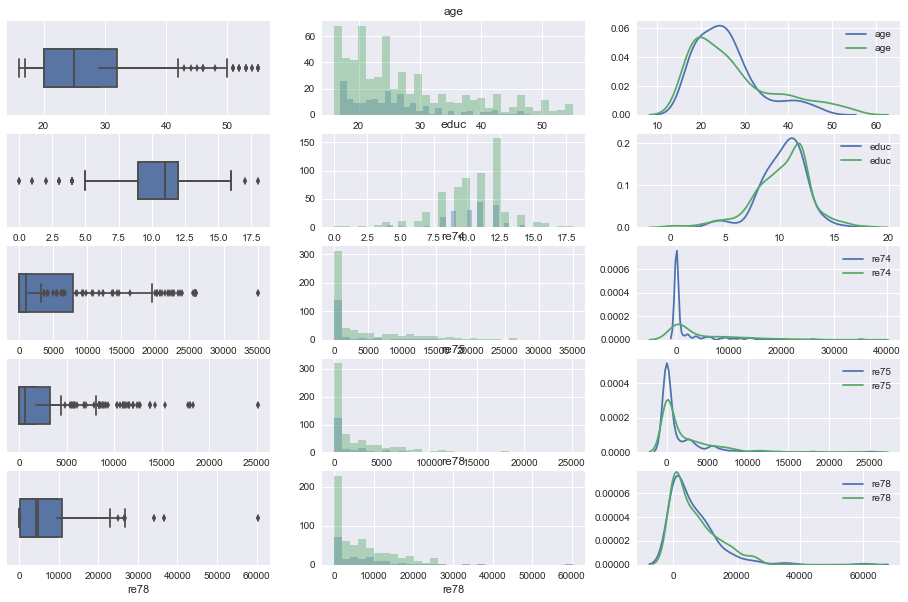

In [5]:
plot_distributions(treated, df, ['id', 'treat', 'black', 'hispan', 'married', 'nodegree'])

We can see that........

#### Binary Features

In [6]:
def binary_proportions(dataframe):
    proportions = []
    for serie in dataframe:
        proportions.append(dataframe[serie].sum()/dataframe[serie].count())
    return proportions

In [7]:
treated_proportions = binary_proportions(treated.iloc[:,[4,5,6,7]])
control_proportions = binary_proportions(control.iloc[:,[4,5,6,7]])

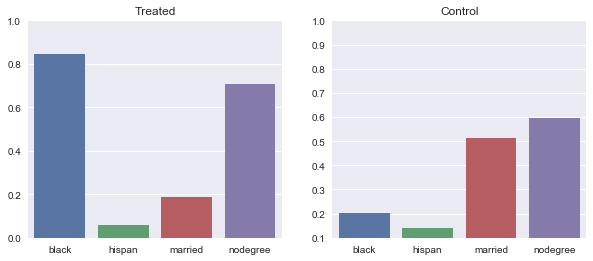

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.set_ylim(0,1)
ax2.set_ylim(0.1)
sns.barplot(y=treated_proportions, x=['black', 'hispan', 'married', 'nodegree'], orient='v', ax=ax1).set_title('Treated')
sns.barplot(y=control_proportions, x=['black', 'hispan', 'married', 'nodegree'], orient='v', ax=ax2).set_title('Control')

Blablabalbalbalbalablabbala

### 1.3 A propensity score model

In [9]:
from sklearn import linear_model

logistic = linear_model.LogisticRegression()
X = df.drop(['id','treat','re78'], axis=1)
y = df['treat']
logistic.fit(X, y)
y_pred_proba = logistic.predict_proba(X)

In [16]:
df['score'] = y_pred_proba[:, 1]

display(df.head())
display(df.tail())

#Create the 2 groups
treated = df.loc[df['treat'] == 1]
control = df.loc[df['treat'] == 0]

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score
609,PSID425,0,18,11,0,0,0,1,0.0,0.0,10150.5000,0.136895
610,PSID426,0,24,1,0,1,1,1,0.0,0.0,19464.6100,0.108708
611,PSID427,0,21,18,0,0,0,0,0.0,0.0,0.0000,0.123129
612,PSID428,0,32,5,1,0,1,1,0.0,0.0,187.6713,0.550460
613,PSID429,0,16,9,0,0,0,1,0.0,0.0,1495.4590,0.155030


### 1.4 Balancing the dataset via matching


In [18]:
#take only relevant value of df and add a temporary col to it in order to merge
treated = treated.loc[:, ['id', 'score']]
treated['temp'] = 1

#take only relevant value of df and add a temporary col to it in order to merge
control = control.loc[:, ['id', 'score']]
control['temp'] = 1

In [22]:
difference = []
for score_treated in (treated['score']):
    for score_controled in (control['score']):
        difference.append(abs(score_treated - score_controled))

In [23]:
newDF = treated.merge(control, on='temp')
newDF['dist'] = difference
newDF.drop(['temp'], axis=1, inplace=True)
display(newDF.sort_values(by=['dist'], ascending = True))

,id_x,score_x,id_y,score_y,dist
20109,NSW47,0.720684,PSID376,0.720684,0.000000e+00
14529,NSW34,0.735773,PSID373,0.735773,0.000000e+00
44560,NSW104,0.677650,PSID374,0.677650,0.000000e+00
26137,NSW61,0.720684,PSID398,0.720684,0.000000e+00
5099,NSW12,0.721376,PSID381,0.721376,0.000000e+00
26115,NSW61,0.720684,PSID376,0.720684,0.000000e+00
44575,NSW104,0.677650,PSID389,0.677650,0.000000e+00
18393,NSW43,0.720684,PSID376,0.720684,0.000000e+00
14542,NSW34,0.735773,PSID386,0.735773,0.000000e+00
13270,NSW31,0.693346,PSID401,0.693346,0.000000e+00


TODO : keep lowest distance, check for repetitions...

In [ ]:
final_DF = pd.DataFrame(['id_x', 'id_y', 'dist'])
for row in newDF:
    if(newDF[row, 'id_x'] ):
        final_DF.append(row)
        
    

# Question 2: Applied ML

## 2.1 Data loading and features extraction

First we will download the dataset as explained and take a look at the dataset. It is a collection of approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups. For more information go to [this website](http://qwone.com/~jason/20Newsgroups/). The data is composed of multiple fields.

* `data`: is the actual text and description of the news.
* `target`: is the label (as integers) of the news that are part of the 20 categories present in `target_names` (displayed later).
* `filename`: is the location of the file.
* `descritpion`: is the title of the dataset, here : "the 20 newsgroups by date dataset".
* `DESCR` is empty
* `target_names`: is the list of target we are trying to match (news categories linked to `target`).

In [ ]:
newsgroups = fetch_20newsgroups(subset='all')

In [ ]:
list(newsgroups.keys())

Note that some labels are actually sub categroies. For example `politics.guns` and `politics.mideast` are both subcategories of `talk`. We can expect it will be more difficult to discriminate and classify news that are part of the same category.

In [ ]:
newsgroups.target_names

We can now create our TF-IDF matrix. The matrix will be sparse and huge since we are not removing any words or limiting the number of features. Here for example the size of vocabulary (features) is 173762.

In [ ]:
tfidf = TfidfVectorizer()
x_tfidf = tfidf.fit_transform(newsgroups.data) 
len(tfidf.vocabulary_)

As asked we will split our data in 3 different sets: `train` (80%), `validation` (10%) and `test` (10%). We will assert our results on the validation set before testing it on the test set. Note that we fixed the seed to 0 for reproducibility purposes.

In [ ]:
ratio_train = 0.8
ratio_validation = 0.1

np.random.seed(0)
id_ = np.random.permutation(np.arange(x_tfidf.shape[0]))
id_train = id_[:np.ceil(x_tfidf.shape[0]*ratio_train).astype(int)]
id_validation = id_[np.floor(x_tfidf.shape[0]*ratio_train).astype(int):
                    np.ceil(x_tfidf.shape[0]*(ratio_train+ratio_validation)).astype(int)]
id_test = id_[np.floor(x_tfidf.shape[0]*(ratio_train+ratio_validation)).astype(int):]

Now that we randomly split our data ids we can create our features sets and labels for classification.

In [ ]:
x_train = x_tfidf[id_train]
x_validation = x_tfidf[id_validation]
x_test = x_tfidf[id_test]

y_train = newsgroups.target[id_train]
y_validation = newsgroups.target[id_validation]
y_test = newsgroups.target[id_test]

## 2.2 Classification using Random Forest

### 2.2.1 Train and Validation set

We decided to go from 0 to around 200 features for both `max_depth` and `n_estimators`. Note that we choosed a logaritmic scale for features numbers since there are no resons to compare values such as for example `max_depth`=63 to `max_depth`=64 since they will give similar results.

In [ ]:
span_depth = np.ceil(np.logspace(0, 2.3, 15)).astype(int)
span_estimators = np.ceil(np.logspace(0, 2.3, 15)).astype(int)

In [ ]:
score = np.zeros((span_depth.shape[0], span_estimators.shape[0]))

for i, n_depth in enumerate(span_depth):
    for j, n_estimator in enumerate(span_estimators):
        clf = RandomForestClassifier(max_depth=n_depth, n_estimators=n_estimator, random_state=0, n_jobs=-1)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_validation)
        score[i, j] = accuracy_score(y_pred, y_validation)
    print('Step {}/{} - Best accuracy max_depth={} is {:.4f}'.format(
        i+1, len(span_depth), n_depth, np.max(score[i])))

Since the grid search takes some time to run we saved the results to save time for next runs. Of course you can run the code from scratch at any time to test the results.

In [ ]:
np.save('score_random_forest.npy', 
        {'max_depth': span_depth, 'n_estimators': span_estimators, 'score': score})

In [ ]:
data = np.load('score_random_forest.npy')[()]

We can take a look at the accuracies and we observe that the larger the parameters `n_estimators` and `max_depth` are, the better the accuracy is. However we can also observe that we are reaching some limit. It seems that the algorithm is reaching a plateau around 86%.

In [ ]:
df_score = pd.DataFrame(data['score'])
df_score.columns = [str(num) for num in data['n_estimators']]
df_score.index = [str(num) for num in data['max_depth']]

plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_score, annot=True, fmt=".2f", cmap='RdYlGn')
ax.set_xlabel('n_estimators'); ax.set_ylabel('max_depth');
ax.set_title('Accuracy score over "Max Depth" and "N Estimators"')

Here we can even more clearly see that we reached a plateau. There is only 4% augmentation in accuray for a difference of 169 in # of Estimators. As a consequence, we choosed to not try with higher values since they will not represent a significative improvement in accuracy.

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_score.index, df_score.iloc[-1], label='max_d=200')
plt.plot(df_score.index, df_score.iloc[-3], label='max_d=94')
plt.plot(df_score.index, df_score.iloc[-6], label='max_d=31')
plt.xlabel('# Estimators'); plt.ylabel('Accuracy in %'); plt.grid(); 
plt.title('Accuracy on validation set as a funtion of MaxDepth and #Estimators'); plt.legend()

### 2.2.2 Results on Test set

We used the values we best score on validation set e.i. (Max Depth, # Estimators) = (200, 200). We can see that the result on the test set is similar to the one on the validation set with around 86% in accuracy. 

In [ ]:
clf = RandomForestClassifier(max_depth=200, n_estimators=200, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print('Accuracy on train set is {:.4f}'.format(accuracy_score(y_pred, y_test)))

To look more carefuly at the results we can compute the confusion matrix. Note that, by default, the matrix is not normalized and it is difficult to look at coherence of the results. We choosed to normalize it with 

$$\text{precision}_j = \frac{\text{tp}_j}{\text{tp}_j + \sum_{i \neq j} \text{fp}_i} $$

where $\text{tp}_j$ is the amount of true positive and $\text{fp}_i$ are the number of false positive for each class $j$. Note that we did not consider recall in this case.

In [ ]:
cm = confusion_matrix(y_pred, y_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
df_conf = pd.DataFrame(cm)
df_conf.columns = newsgroups.target_names
df_conf.index = newsgroups.target_names

We can see that most classes are performing well with values close to 1. However we can see that some classes such as `soc.religion.christian` only have around 0.7 precision. It is interesting to notice that most of the fp are acually part of `talk.religion.misc` and fewer are `alt.atheism`. Those two topics are indeed related to the first one and we can conclude classification is harder. It is also interesting to notice that `misc.forsale` have fp spread around other classes such as `sci.electronics`, `comp.sys.mac.hardware`, or even `comp.graphics`. Thoses make also sense since this category (forsale) can include a lot of electronic devices and miscellaneous objects.

In [ ]:
plt.figure(figsize=(14, 10))
ax = sns.heatmap(df_conf, annot=True, fmt=".2f", cmap='RdYlGn')

### 2.2.3 Feature Importances
Let's now look at the features more carefuly. If we plot the repartition of the feature importances we can see that there are actually a lot of features that have little importance in classification (close to 0). Moreover there are only around 20 feature that are above 0.002. Note that the y scale is logaritmic. 

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(clf.feature_importances_, bins=50)
plt.yscale('log', nonposy='clip')
plt.xlabel('Feature importance'); plt.ylabel('#Features');
plt.grid(); plt.title('Repartition of feature importance')

As explained before it seems that a small set of top feature have huge impact on clssification. Let's display the 50 with highest importance and therefore look at the relevant words use for classification. It is interessting to notice that some words are actually part of the categories (labels) names. For example "baseball" with `rec.sport.baseball`, "gun" with `talk.politics.gun` or "sale" with `forsale`. However it is wierd to have some unrelevant words such as "are", "you", "for", "the" or even "it" that are often considered as stop words.

In [ ]:
n_features = 50
id_max = np.argsort(clf.feature_importances_)[-n_features:]
np.array(tfidf.get_feature_names())[id_max]